In [ ]:
# Load all needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
import random
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from numpy.random import seed
from sklearn.metrics import *
import seaborn as sns
from progressbar import Bar
seed(1)


#Data Set 

The project goal is to classify routes of bus trips. The idea was to generate many images of each route. Then divide the images generated in train/test data sets. 


Currently our images are stored on Google Drive, and this notebook connects directly to google drive load the images and train the model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# dataset paths
dir = "/content/drive/Shared drives/DS4A-T76/DS4A-Team76"
train_dir = dir + '/data/dataset/dataset_split/train'
test_dir = dir + '/data/dataset/dataset_split/test'
csv_path = 'cnt_images.csv'

##Load Dataset

Dataset Dataframe

In [ ]:
count_csv = pd.read_csv(csv_path)
count_csv.route = count_csv.route.apply(lambda x: x[2:])
count_csv

,route,cnt
0,295,108
1,277,153
2,653,31
3,286,1
4,280,125
5,281,44
6,655,187
7,585,14
8,169,64
9,656,31


In [ ]:
count_csv.columns

Index(['route', 'cnt'], dtype='object')

### Weights 

In order to balance the data, due to the fact that there is
a significant difference between the number of paintings per
author, weights were assigned to each class
(route) using an inverse relationship between the number of
images per route, so a class corresponding to a route with
a small number of paintings have bigger weight than a class
corresponding to a route with a large number of paintings.

In [ ]:
# Sort artists by number of paintings
routes = count_csv.sort_values(by=['cnt'], ascending=False)

# Create a dataframe with artists having more than 70 paintings
routes_top = routes[routes['cnt'] >= 10 ].reset_index(drop=True)
routes_top = routes_top[routes_top['route'] != "0" ].reset_index(drop=True)



# Add class weights 
routes_top['class_weight'] = routes_top.cnt.sum() / (routes_top.shape[0] * routes_top.cnt)


routes_top

,route,cnt,class_weight
0,655,187,0.472727
1,277,153,0.577778
2,654,129,0.685271
3,172,126,0.701587
4,280,125,0.707200
5,272,124,0.712903
6,295,108,0.818519
7,634,91,0.971429
8,170,82,1.078049
9,169,64,1.381250


In [ ]:
# Verificatoin of data and directories
images_dir = dir + '/data/dataset/dataset_split/train'
routes_dirs = os.listdir(images_dir)
routes_name = routes_top['route']

# See if all directories exist
for name in routes_name:
    if os.path.exists(os.path.join(images_dir, name)):
        print("Found -->", os.path.join(images_dir, name))
    else:
        print("Did not find -->", os.path.join(images_dir, name))

Found --> /content/drive/Shared drives/DS4A-T76/DS4A-Team76/data/dataset/dataset_split/train/655
Found --> /content/drive/Shared drives/DS4A-T76/DS4A-Team76/data/dataset/dataset_split/train/277
Found --> /content/drive/Shared drives/DS4A-T76/DS4A-Team76/data/dataset/dataset_split/train/654
Found --> /content/drive/Shared drives/DS4A-T76/DS4A-Team76/data/dataset/dataset_split/train/172
Found --> /content/drive/Shared drives/DS4A-T76/DS4A-Team76/data/dataset/dataset_split/train/280
Found --> /content/drive/Shared drives/DS4A-T76/DS4A-Team76/data/dataset/dataset_split/train/272
Found --> /content/drive/Shared drives/DS4A-T76/DS4A-Team76/data/dataset/dataset_split/train/295
Found --> /content/drive/Shared drives/DS4A-T76/DS4A-Team76/data/dataset/dataset_split/train/634
Found --> /content/drive/Shared drives/DS4A-T76/DS4A-Team76/data/dataset/dataset_split/train/170
Found --> /content/drive/Shared drives/DS4A-T76/DS4A-Team76/data/dataset/dataset_split/train/169
Found --> /content/drive/Share

## Data Processing

## Print few random images


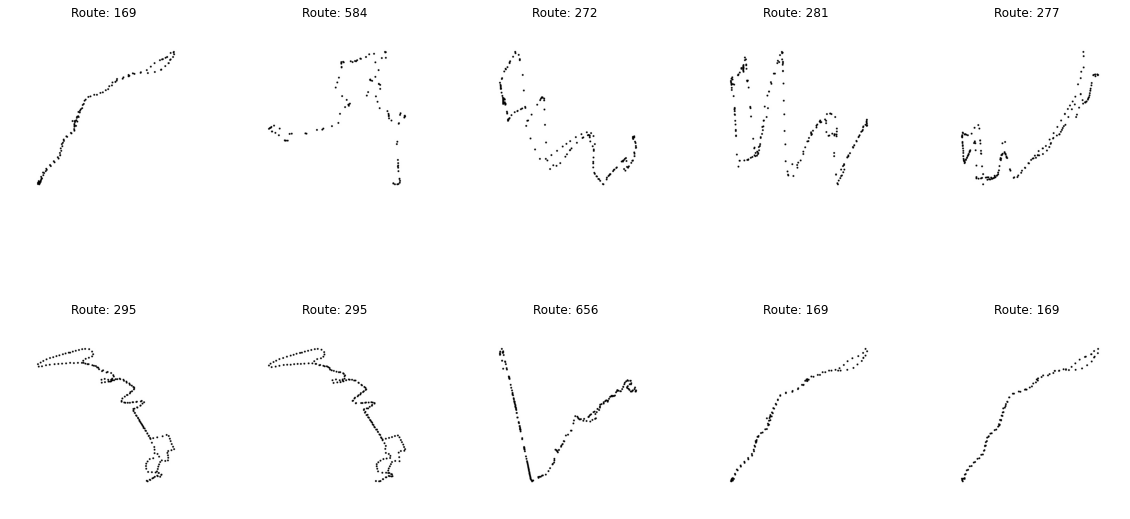

In [ ]:
# Print 10 random paintings
n = 5
fig, axes = plt.subplots(2, n, figsize=(20,10))

for i in range(n):
    random_route = random.choice(routes_name)
    random_image = random.choice(os.listdir(os.path.join(images_dir, random_route)))
    random_image_file = os.path.join(images_dir, random_route, random_image)
    image = plt.imread(random_image_file)
    axes[0][i].imshow(image)
    axes[0][i].set_title("Route: " + random_route)
    axes[0][i].axis('off')

for i in range(n):
    random_route = random.choice(routes_name)
    random_image = random.choice(os.listdir(os.path.join(images_dir, random_route)))
    random_image_file = os.path.join(images_dir, random_route, random_image)
    image = plt.imread(random_image_file)
    axes[1][i].imshow(image)
    axes[1][i].set_title("Route: " + random_route)
    axes[1][i].axis('off')


plt.show()

# Data Generators

The dataset was divided into test and training set using a proportion of 70% - 30% respectively, from the training partition, is taken 10% of the data as the validation set. The data was divided into two different directories, one for training and one for testing. Each one of these folders was divided into the respective artists. This partition seeks been able to test the model with unseen data, an


In [ ]:
# Augment data
batch_size = 16
train_input_shape = (224, 224, 3)
n_classes = routes_top.shape[0]

train_datagen = ImageDataGenerator(validation_split=0.1,
                  rescale=1./255.,
                  rotation_range=45,
                  width_shift_range=0.2,
                  height_shift_range=0.2,
                  shear_range=5,
                  zoom_range=0.4,
                  horizontal_flip=True,
                  vertical_flip=True,
                )

train_generator = train_datagen.flow_from_directory(directory=train_dir,
                        class_mode='categorical',
                        target_size=train_input_shape[0:2],
                        batch_size=batch_size,
                        subset="training",
                        shuffle=True,
                        classes=routes_name.tolist()
                        )

valid_generator = train_datagen.flow_from_directory(directory=train_dir,
                        class_mode='categorical',
                        target_size=train_input_shape[0:2],
                        batch_size=batch_size,
                        subset="validation",
                        shuffle=True,
                        classes=routes_name.tolist()
                        )

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN," for training and ", STEP_SIZE_VALID, "for validation")

Found 833 images belonging to 15 classes.
Found 86 images belonging to 15 classes.
Total number of batches = 52  for training and  5 for validation


## Few samples of data augmentation

To increase the number of pictures to train our model, we
use a data augmentation technique, where some transforma-
tions like rotation and scale, are applied to the original image.

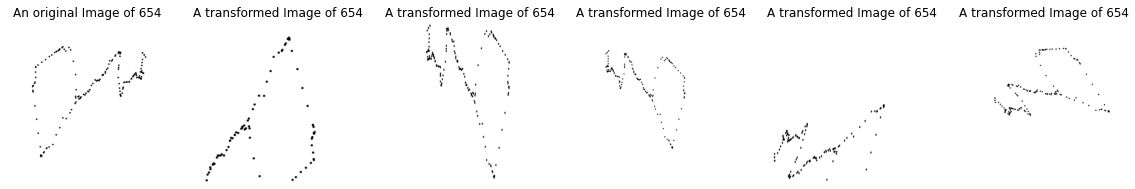

In [ ]:
# Print a random paintings and it's random augmented version
n_fig = 6
fig, axes = plt.subplots(1, n_fig, figsize=(20,10))

random_route = random.choice(routes_name)
random_image = random.choice(os.listdir(os.path.join(images_dir, random_route)))
random_image_file = os.path.join(images_dir, random_route, random_image)

# Original image
image = plt.imread(random_image_file)
axes[0].imshow(image)
axes[0].set_title("An original Image of " + random_route)
axes[0].axis('off')

  # Transformed image
for i in range(1,n_fig):
  aug_image = train_datagen.random_transform(image)
  axes[i].imshow(aug_image)
  axes[i].set_title("A transformed Image of " + random_route)
  axes[i].axis('off')

plt.show()

## Sample of a batch with data augmentation


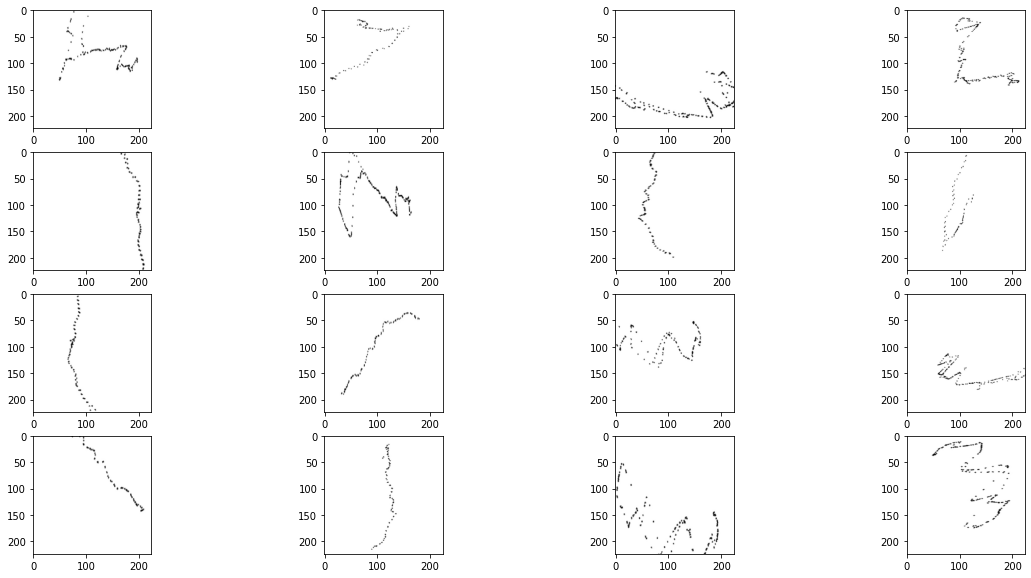

In [ ]:
fig, axes = plt.subplots(4, 4, figsize=(20,10))
m = 0
for x,y in train_generator:
  if m == 1:
    break
  m+=1 
  for i in range(4):
    for j in range(4):
      axes[i][j].imshow(x[4*i+j])
plt.show()

# Build And Train Models 



## RestNet50


In [ ]:
# Load pre-trained model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=train_input_shape)

for layer in base_model.layers:
    layer.trainable = True

base_model.summary() 

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
# Add layers at the end
X = base_model.output
X = Flatten()(X)

X = Dense(512, kernel_initializer='he_uniform')(X)
#X = Dropout(0.5)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = Dense(128, kernel_initializer='he_uniform')(X)
#X = Dropout(0.5)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

output = Dense(n_classes, activation='softmax')(X)

model_resnetv2 = Model(inputs=base_model.input, outputs=output)

model_resnetv2.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [ ]:
optimizer = Adam(lr=0.0001)
model_resnetv2.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

In [ ]:
n_epoch = 10

early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')

In [ ]:
class_weights = {}
for i, d in enumerate(routes_top.iterrows()):
  class_weights[i] = d[1].class_weight
class_weights

{0: 0.4727272727272727,
 1: 0.5777777777777777,
 2: 0.6852713178294574,
 3: 0.7015873015873015,
 4: 0.7072,
 5: 0.7129032258064516,
 6: 0.8185185185185185,
 7: 0.9714285714285714,
 8: 1.078048780487805,
 9: 1.38125,
 10: 2.0090909090909093,
 11: 2.8516129032258064,
 12: 2.8516129032258064,
 13: 5.2,
 14: 6.314285714285714}

In [ ]:
# Train the model - all layers
history1 = model_resnetv2.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                epochs=n_epoch,
                shuffle=True,
                verbose=1,
                callbacks=[reduce_lr],
                use_multiprocessing=True,
                workers=16,
                class_weight=class_weights
                )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
52/52 [==============================] - 47s 896ms/step - loss: 1.9879 - accuracy: 0.3953 - val_loss: 3.4729 - val_accuracy: 0.0875
Epoch 2/10
52/52 [==============================] - 15s 290ms/step - loss: 1.1440 - accuracy: 0.6732 - val_loss: 3.1180 - val_accuracy: 0.0000e+00
Epoch 3/10
52/52 [==============================] - 15s 289ms/step - loss: 0.7800 - accuracy: 0.7980 - val_loss: 3.4654 - val_accuracy: 0.0000e+00
Epoch 4/10
52/52 [==============================] - 15s 282ms/step - loss: 0.6348 - accuracy: 0.8262 - val_loss: 3.8412 - val_accuracy: 0.0750
Epoch 5/10
52/52 [==============================] - 15s 286ms/step - loss: 0.4766 - accuracy: 0.8813 - val_loss: 4.3500 - val_accuracy: 0.0000e+00
Epoch 6/10
52/52 [==============================] - 15s 297ms/step - loss: 0.4467 - accuracy: 0.9106 - val_loss: 4.2980 - val_accuracy: 0.0625
Epoch 7/10
52/52 [==============================] - ET

In [ ]:
!cd /content/drive/Shared\ drives/DS4A-T76/DS4A-Team76 && ls models/ResNet50/

In [ ]:
# dir dir /content/drive/Shared drives/DS4A-T76/DS4A-Team76
model_dir = dir + "/models/ResNet50/"

In [ ]:
# Set checkpoint callback
filepath="/weights_resnet.hdf5"

checkpoint = ModelCheckpoint(model_dir + filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [ ]:
# Freeze core ResNet layers and train again 
for layer in model_resnetv2.layers:
    layer.trainable = False

for layer in model_resnetv2.layers[:50]:
    layer.trainable = True

optimizer = Adam(lr=0.0001)

model_resnetv2.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

n_epoch = 40
history2 = model_resnetv2.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr, early_stop, checkpoint],
                              use_multiprocessing=True,
                              workers=16,
                             class_weight=class_weights
                             )

Epoch 1/40
52/52 [==============================] - ETA: 0s - loss: 0.1563 - accuracy: 0.9816WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.

Epoch 00001: val_accuracy improved from -inf to 0.10000, saving model to /content/drive/Shared drives/DS4A-T76/DS4A-Team76/models/ResNet50/weights_resnet.hdf5
52/52 [==============================] - 17s 336ms/step - loss: 0.1563 - accuracy: 0.9816 - val_loss: 3.7302 - val_accuracy: 0.1000
Epoch 2/40
52/52 [==============================] - ETA: 0s - loss: 0.1965 - accuracy: 0.9645WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.

Epoch 00002: val_accuracy did not improve from 0.10000
52/52 [==============================] - 15s 297ms/step - loss: 0.1965 - accuracy: 0.9645 - val_loss: 3.7158 - val_accuracy: 0.0750


In [ ]:
# Merge history1 and history2
history = {}
history['loss'] = history1.history['loss'] + history2.history['loss']
history['accuracy'] = history1.history['accuracy'] + history2.history['accuracy']
history['val_loss'] = history1.history['val_loss'] + history2.history['val_loss']
history['val_accuracy'] = history1.history['val_accuracy'] + history2.history['val_accuracy']
history['lr'] = history1.history['lr'] + history2.history['lr']

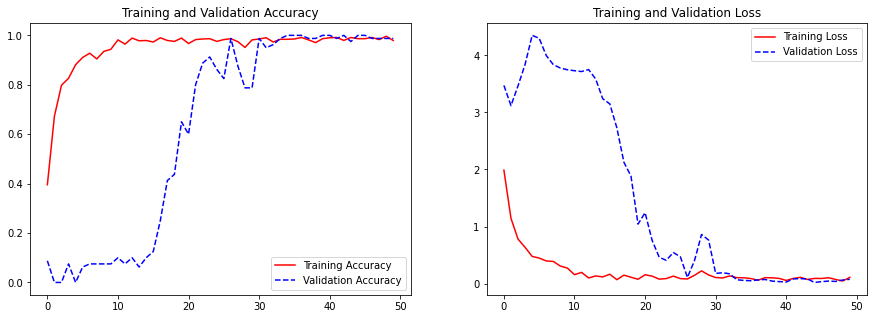

In [ ]:
# Plot the training graph
def plot_training(history):
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(len(acc))

    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    
    axes[0].plot(epochs, acc, 'r-', label='Training Accuracy')
    axes[0].plot(epochs, val_acc, 'b--', label='Validation Accuracy')
    axes[0].set_title('Training and Validation Accuracy')
    axes[0].legend(loc='best')

    axes[1].plot(epochs, loss, 'r-', label='Training Loss')
    axes[1].plot(epochs, val_loss, 'b--', label='Validation Loss')
    axes[1].set_title('Training and Validation Loss')
    axes[1].legend(loc='best')
    
    plt.show()
    
plot_training(history)

## Load Test set


In [ ]:
images_dir = dir + '/data/dataset/dataset_split/test'
routes_dirs = os.listdir(images_dir)
routes_name = routes_top['route']

# See if all directories exist
for name in routes_name:
    if os.path.exists(os.path.join(images_dir, name)):
        print("Found -->", os.path.join(images_dir, name))
    else:
        print("Did not find -->", os.path.join(images_dir, name))

Found --> /content/drive/Shared drives/DS4A-T76/DS4A-Team76/data/dataset/dataset_split/test/655
Found --> /content/drive/Shared drives/DS4A-T76/DS4A-Team76/data/dataset/dataset_split/test/277
Found --> /content/drive/Shared drives/DS4A-T76/DS4A-Team76/data/dataset/dataset_split/test/654
Found --> /content/drive/Shared drives/DS4A-T76/DS4A-Team76/data/dataset/dataset_split/test/172
Found --> /content/drive/Shared drives/DS4A-T76/DS4A-Team76/data/dataset/dataset_split/test/280
Found --> /content/drive/Shared drives/DS4A-T76/DS4A-Team76/data/dataset/dataset_split/test/272
Found --> /content/drive/Shared drives/DS4A-T76/DS4A-Team76/data/dataset/dataset_split/test/295
Found --> /content/drive/Shared drives/DS4A-T76/DS4A-Team76/data/dataset/dataset_split/test/634
Found --> /content/drive/Shared drives/DS4A-T76/DS4A-Team76/data/dataset/dataset_split/test/170
Found --> /content/drive/Shared drives/DS4A-T76/DS4A-Team76/data/dataset/dataset_split/test/169
Found --> /content/drive/Shared drives/D

In [ ]:
test_datagen = ImageDataGenerator(
                  rescale=1./255.,
                )
test_generator = train_datagen.flow_from_directory(directory=images_dir,
                        class_mode='categorical',
                        target_size=train_input_shape[0:2 ],
                        batch_size=1,
                        shuffle=False,
                        classes=routes_name.tolist()
                        )


Found 407 images belonging to 15 classes.


## Restnet50

In [ ]:
# Load weights 
# run if want to load a model
model_dir = dir + "/models/ResNet50/"

model_resnetv2.load_weights(model_dir + "weights_resnet.hdf5")  # Best model weights 

In [ ]:
# Prediction accuracy on test data
score = model_resnetv2.evaluate_generator(test_generator, verbose=1)
print("Prediction accuracy on test data =", score[1])

Instructions for updating:
Please use Model.evaluate, which supports generators.
407/407 [==============================] - 136s 333ms/step - loss: 0.1059 - accuracy: 0.9803
Prediction accuracy on test data = 0.9803439974784851


### Testing with top1 value

In [ ]:
tick_labels = routes_name.tolist()
figsize=(30,30)
from progressbar import progressbar
def showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID):
    # Loop on each generator batch and predict
    #print("Making predictions...", STEP_SIZE_VALID)
    y_pred, y_true = [], []
    for i in progressbar(range(STEP_SIZE_VALID)):
        (X,y) = next(test_generator)
        y_pred.append(model.predict(X))
        y_true.append(y)
    # Create a flat list for y_true and y_pred
    y_pred = [subresult for result in y_pred for subresult in result]
    y_true = [subresult for result in y_true for subresult in result]

    # Update Truth vector based on argmax
    y_true = np.argmax(y_true, axis=1)
    y_true = np.asarray(y_true).ravel()
    
    # Update Prediction vector based on argmax
    y_pred = np.argmax(y_pred, axis=1)
    y_pred = np.asarray(y_pred).ravel()
    
    # Confusion Matrix

    conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))

    conf_matrix = conf_matrix/np.sum(conf_matrix, axis=1)[:,None]
    fig, ax = plt.subplots(figsize=(20,20))
    sns.heatmap(conf_matrix, annot=True, fmt=".2f", square=True, cbar=False, 
                cmap=plt.cm.jet, xticklabels=tick_labels, yticklabels=tick_labels,
                ax=ax)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_title('Confusion Matrix')
    plt.show()
    
    #print('Classification Report:')
    Class_report = classification_report(y_true, y_pred, labels=np.arange(n_classes), target_names=routes_name.tolist())
    return Class_report

STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
print("Test set size: ", STEP_SIZE_TEST)


Test set size:  407


In [ ]:

class_report_res_top1 = showClassficationReport_Generator(model_resnetv2, test_generator, STEP_SIZE_TEST)

In [ ]:
print('Classification Report Resnet50 with Top1 value:')
print(class_report_res_top1)

Classification Report Resnet50 with Top1 value:
              precision    recall  f1-score   support

         655       1.00      0.98      0.99        57
         277       1.00      1.00      1.00        46
         654       0.93      0.97      0.95        39
         172       0.97      1.00      0.99        38
         280       1.00      0.97      0.99        38
         272       1.00      0.95      0.97        38
         295       1.00      0.97      0.98        33
         634       1.00      0.96      0.98        28
         170       1.00      1.00      1.00        25
         169       0.95      1.00      0.98        20
         281       0.93      1.00      0.97        14
         656       1.00      1.00      1.00        10
         653       1.00      0.90      0.95        10
         584       0.86      1.00      0.92         6
         585       0.67      0.80      0.73         5

    accuracy                           0.98       407
   macro avg       0.95      0.9

# Random Prediction Samples 

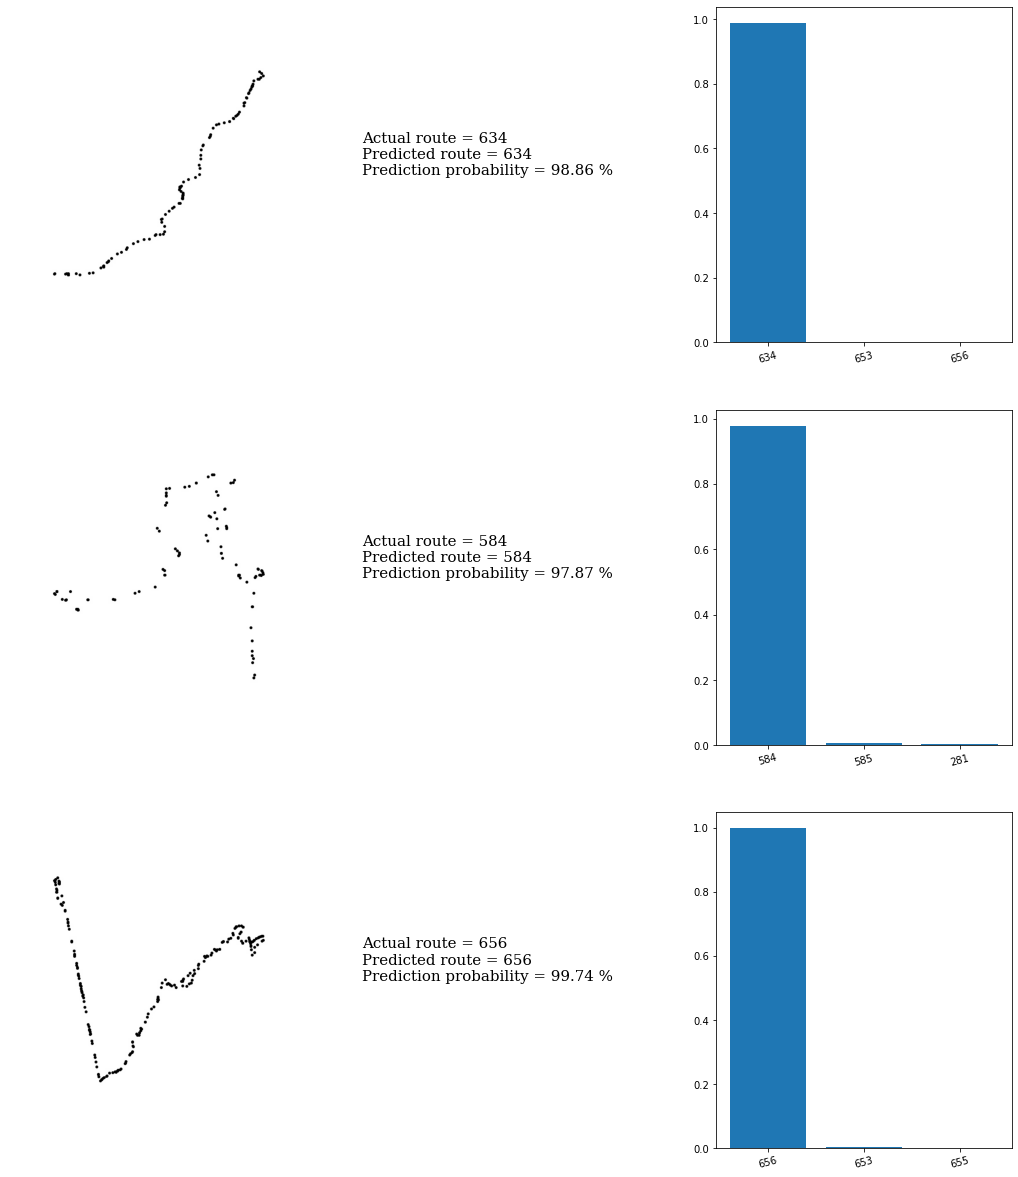

In [ ]:
# Prediction
from keras.preprocessing import *

n = 3
top_n = 3
fig, axes = plt.subplots(n, 3, figsize=(18,7*n))

for i in range(n):
    random_route = random.choice(routes_name)
    random_image = random.choice(os.listdir(os.path.join(images_dir, random_route)))
    random_image_file = os.path.join(images_dir, random_route, random_image)

    # Original image

    test_image = image.load_img(random_image_file, target_size=(train_input_shape[0:2]))

    # Predict artist
    test_image = image.img_to_array(test_image)
    test_image /= 255.
    test_image = np.expand_dims(test_image, axis=0)

    prediction = model_resnetv2.predict(test_image)
    prediction_probability = np.amax(prediction)
    prediction_idx = np.argmax(prediction)

    labels = train_generator.class_indices
    labels = dict((v,k) for k,v in labels.items())

    title = "Actual route = {}\nPredicted route = {}\nPrediction probability = {:.2f} %" \
                .format(random_route, labels[prediction_idx],
                        prediction_probability*100)
    axes[i][1].text(0,0.5,title,fontsize=15,family='serif')
    axes[i][1].axis('off')


    axes[i][0].imshow(plt.imread(random_image_file))


    axes[i][0].axis('off')

    top = list(enumerate(prediction[0]))
    top.sort(key= lambda x: x[1],reverse=True)
    probas = [p[1] for p in top[:top_n]]
    names = [labels[p[0] ]for p in top[:top_n]]

    x = np.arange(top_n)
    axes[i][2].bar(x,probas)
    axes[i][2].set_xticks(x)
    axes[i][2].set_xticklabels(names,rotation=15)
plt.savefig("abc.png")
plt.show()

In [ ]:

labels = train_generator.class_indices
labels = dict((v,k) for k,v in labels.items())
labels

{0: '655',
 1: '277',
 2: '654',
 3: '172',
 4: '280',
 5: '272',
 6: '295',
 7: '634',
 8: '170',
 9: '169',
 10: '281',
 11: '656',
 12: '653',
 13: '584',
 14: '585'}

In [ ]:
simple_model = Sequential()
simple_model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=[224, 224, 3]))
simple_model.add(MaxPooling2D((2, 2)))
simple_model.add(Flatten())
simple_model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
simple_model.add(Dense(n_classes, activation='softmax'))
# compile model
opt = SGD(lr=0.01, momentum=0.9)
simple_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
base_model.input.shape

TensorShape([None, 224, 224, 3])

#Simple Model

Now we want to try a simpler model with 5 layers. And with no pretrained networks nor data augmentation



In [ ]:
simple_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 394272)            0         
_________________________________________________________________
dense_9 (Dense)              (None, 100)               39427300  
_________________________________________________________________
dense_10 (Dense)             (None, 15)                1515      
Total params: 39,429,711
Trainable params: 39,429,711
Non-trainable params: 0
_________________________________________________________________


In [ ]:

n_epoch = 10
history_sm = simple_model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,                      
                              use_multiprocessing=True,
                              workers=16,
                             )

Epoch 1/10
52/52 [==============================] - 7s 134ms/step - loss: 4.5857 - accuracy: 0.7785 - val_loss: 0.0085 - val_accuracy: 1.0000
Epoch 2/10
52/52 [==============================] - 7s 130ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 3.7818e-04 - val_accuracy: 1.0000
Epoch 3/10
52/52 [==============================] - 7s 128ms/step - loss: 3.0063e-04 - accuracy: 1.0000 - val_loss: 3.3040e-04 - val_accuracy: 1.0000
Epoch 4/10
52/52 [==============================] - 8s 153ms/step - loss: 1.1559e-04 - accuracy: 1.0000 - val_loss: 2.9750e-04 - val_accuracy: 1.0000
Epoch 5/10
52/52 [==============================] - 7s 129ms/step - loss: 1.1378e-04 - accuracy: 1.0000 - val_loss: 1.7260e-04 - val_accuracy: 1.0000
Epoch 6/10
52/52 [==============================] - 7s 127ms/step - loss: 9.5353e-05 - accuracy: 1.0000 - val_loss: 2.5041e-04 - val_accuracy: 1.0000
Epoch 7/10
52/52 [==============================] - 7s 127ms/step - loss: 8.2191e-05 - accuracy: 1.0000 - val_lo

In [ ]:
score = simple_model.evaluate_generator(test_generator, verbose=1)
print("Prediction accuracy on test data =", score[1])

407/407 [==============================] - 4s 9ms/step - loss: 0.0177 - accuracy: 0.9951
Prediction accuracy on test data = 0.9950860142707825


100% (407 of 407) |######################| Elapsed Time: 0:00:16 Time:  0:00:16


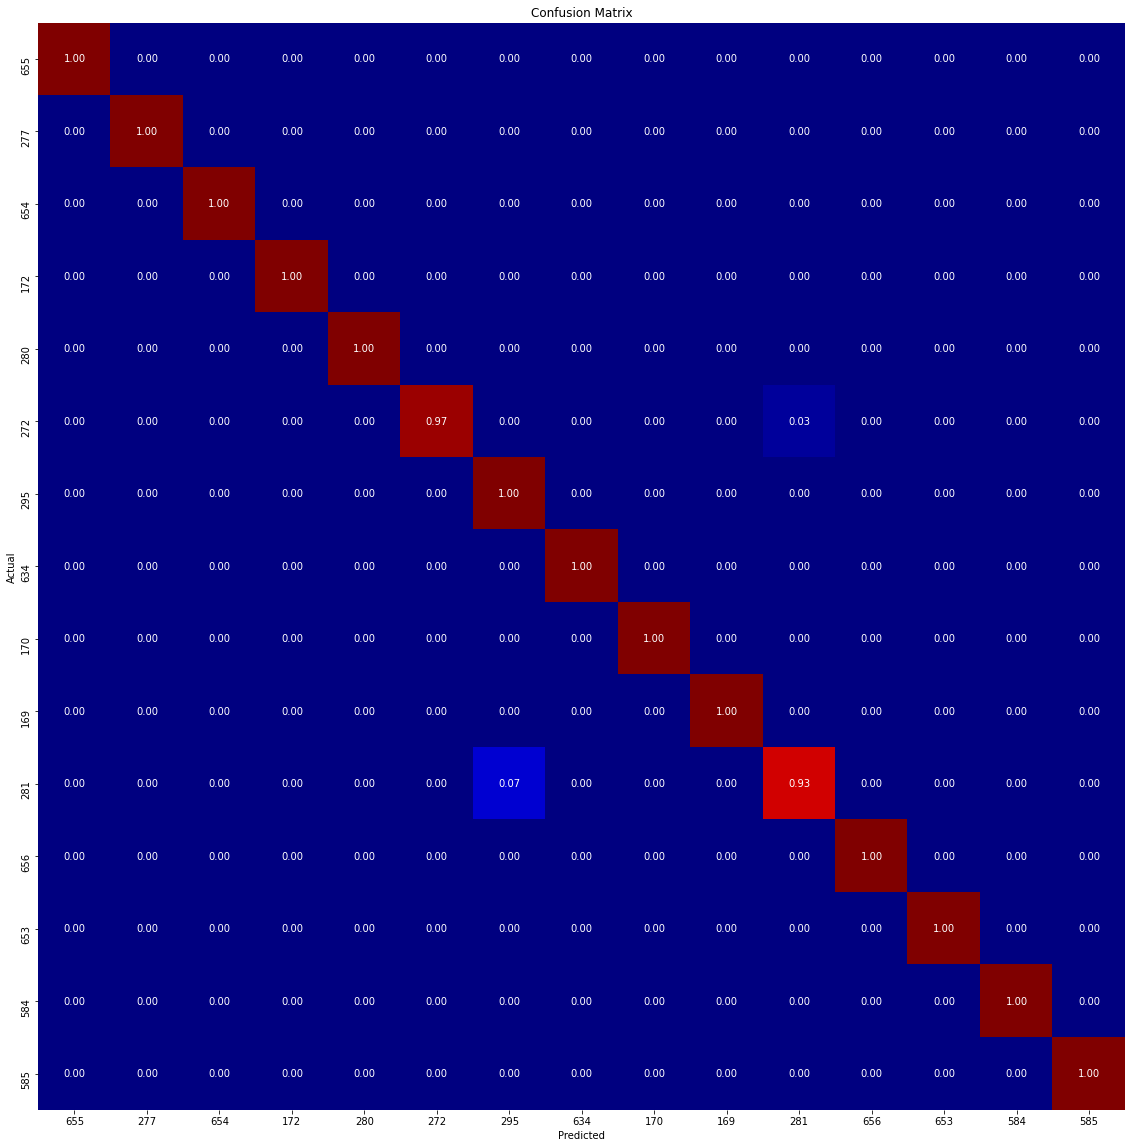

In [ ]:
class_report_res_sm = showClassficationReport_Generator(simple_model, test_generator, STEP_SIZE_TEST)

In [ ]:
print('Classification Report SimpleModel with Top1 value:')
print(class_report_res_sm)

Classification Report SimpleModel with Top1 value:
              precision    recall  f1-score   support

         655       1.00      1.00      1.00        57
         277       1.00      1.00      1.00        46
         654       1.00      1.00      1.00        39
         172       1.00      1.00      1.00        38
         280       1.00      1.00      1.00        38
         272       1.00      0.97      0.99        38
         295       0.97      1.00      0.99        33
         634       1.00      1.00      1.00        28
         170       1.00      1.00      1.00        25
         169       1.00      1.00      1.00        20
         281       0.93      0.93      0.93        14
         656       1.00      1.00      1.00        10
         653       1.00      1.00      1.00        10
         584       1.00      1.00      1.00         6
         585       1.00      1.00      1.00         5

    accuracy                           1.00       407
   macro avg       0.99      

In [ ]:
simple_model2 = Sequential()
simple_model2.add(Conv2D(20, (10, 10), activation='relu', input_shape=[150, 150, 3]))
simple_model2.add(Dense(100, activation='relu'))
simple_model2.add(MaxPooling2D((2, 2)))
simple_model2.add(Flatten())
simple_model2.add(Dense(n_classes, activation='softmax'))
# compile model
opt = SGD(lr=0.001)
simple_model2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
simple_model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 91, 91, 20)        6020      
_________________________________________________________________
dense_2 (Dense)              (None, 91, 91, 100)       2100      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 100)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 202500)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 15)                3037515   
Total params: 3,045,635
Trainable params: 3,045,635
Non-trainable params: 0
_________________________________________________________________


In [ ]:
images_dir = dir + '/data/dataset/dataset_split/test'
routes_dirs = os.listdir(images_dir)
routes_name = routes_top['route']

# See if all directories exist
for name in routes_name:
    if os.path.exists(os.path.join(images_dir, name)):
        print("Found -->", os.path.join(images_dir, name))
    else:
        print("Did not find -->", os.path.join(images_dir, name))

Found --> /content/drive/Shared drives/DS4A-T76/DS4A-Team76/data/dataset/dataset_split/test/655
Found --> /content/drive/Shared drives/DS4A-T76/DS4A-Team76/data/dataset/dataset_split/test/277
Found --> /content/drive/Shared drives/DS4A-T76/DS4A-Team76/data/dataset/dataset_split/test/654
Found --> /content/drive/Shared drives/DS4A-T76/DS4A-Team76/data/dataset/dataset_split/test/172
Found --> /content/drive/Shared drives/DS4A-T76/DS4A-Team76/data/dataset/dataset_split/test/280
Found --> /content/drive/Shared drives/DS4A-T76/DS4A-Team76/data/dataset/dataset_split/test/272
Found --> /content/drive/Shared drives/DS4A-T76/DS4A-Team76/data/dataset/dataset_split/test/295
Found --> /content/drive/Shared drives/DS4A-T76/DS4A-Team76/data/dataset/dataset_split/test/634
Found --> /content/drive/Shared drives/DS4A-T76/DS4A-Team76/data/dataset/dataset_split/test/170
Found --> /content/drive/Shared drives/DS4A-T76/DS4A-Team76/data/dataset/dataset_split/test/169
Found --> /content/drive/Shared drives/D

In [ ]:
test_datagen = ImageDataGenerator(
                  rescale=1./255.,
                )
test_generator = train_datagen.flow_from_directory(directory=images_dir,
                        class_mode='categorical',
                        target_size=train_input_shape[0:2],
                        batch_size=1,
                        shuffle=False,
                        classes=routes_name.tolist()
                        )

Found 407 images belonging to 15 classes.


In [ ]:
%%time
batch_size = 16
train_input_shape = (150, 150, 3
                     )
n_classes = routes_top.shape[0]

train_datagen = ImageDataGenerator(validation_split=0.1,
                  rescale=1./255.,
                )

train_generator = train_datagen.flow_from_directory(directory=train_dir,
                        class_mode='categorical',
                        target_size=train_input_shape[0:2],
                        batch_size=batch_size,
                        subset="training",
                        shuffle=True,
                        classes=routes_name.tolist()
                        )

valid_generator = train_datagen.flow_from_directory(directory=train_dir,
                        class_mode='categorical',
                        target_size=train_input_shape[0:2],
                        batch_size=batch_size,
                        subset="validation",
                        shuffle=True,
                        classes=routes_name.tolist()
                        )

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN," for training and ", STEP_SIZE_VALID, "for validation")

Found 833 images belonging to 15 classes.
Found 86 images belonging to 15 classes.
Total number of batches = 52  for training and  5 for validation
CPU times: user 28.6 ms, sys: 12.6 ms, total: 41.1 ms
Wall time: 212 ms


##Training


In [ ]:
%%time 
n_epoch = 10
history_sm = simple_model2.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,                      
                              use_multiprocessing=True,
                              workers=16,
                             )

Epoch 1/10
52/52 [==============================] - 6s 108ms/step - loss: 2.3968 - accuracy: 0.2521 - val_loss: 2.0850 - val_accuracy: 0.7250
Epoch 2/10
52/52 [==============================] - 5s 104ms/step - loss: 1.9492 - accuracy: 0.6389 - val_loss: 1.7154 - val_accuracy: 0.7375
Epoch 3/10
52/52 [==============================] - 5s 105ms/step - loss: 1.5114 - accuracy: 0.7882 - val_loss: 1.3367 - val_accuracy: 0.8500
Epoch 4/10
52/52 [==============================] - 5s 100ms/step - loss: 1.1343 - accuracy: 0.8262 - val_loss: 0.8965 - val_accuracy: 0.9250
Epoch 5/10
52/52 [==============================] - 5s 104ms/step - loss: 0.8360 - accuracy: 0.9045 - val_loss: 0.6806 - val_accuracy: 0.9125
Epoch 6/10
52/52 [==============================] - 5s 103ms/step - loss: 0.6125 - accuracy: 0.9547 - val_loss: 0.4874 - val_accuracy: 0.9500
Epoch 7/10
52/52 [==============================] - 5s 102ms/step - loss: 0.4611 - accuracy: 0.9633 - val_loss: 0.3846 - val_accuracy: 0.9875
Epoch 

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
2.8656758609999997
GPU (s):
0.11020043700000315
GPU speedup over CPU: 26x


##Results


In [ ]:
score = simple_model2.evaluate_generator(test_generator, verbose=1)
print("Prediction accuracy on test data =", score[1])

407/407 [==============================] - 3s 9ms/step - loss: 0.2339 - accuracy: 0.9877
Prediction accuracy on test data = 0.9877150058746338


In [ ]:
simple_model2.save("model_weights.hdf5")

100% (407 of 407) |######################| Elapsed Time: 0:00:15 Time:  0:00:15


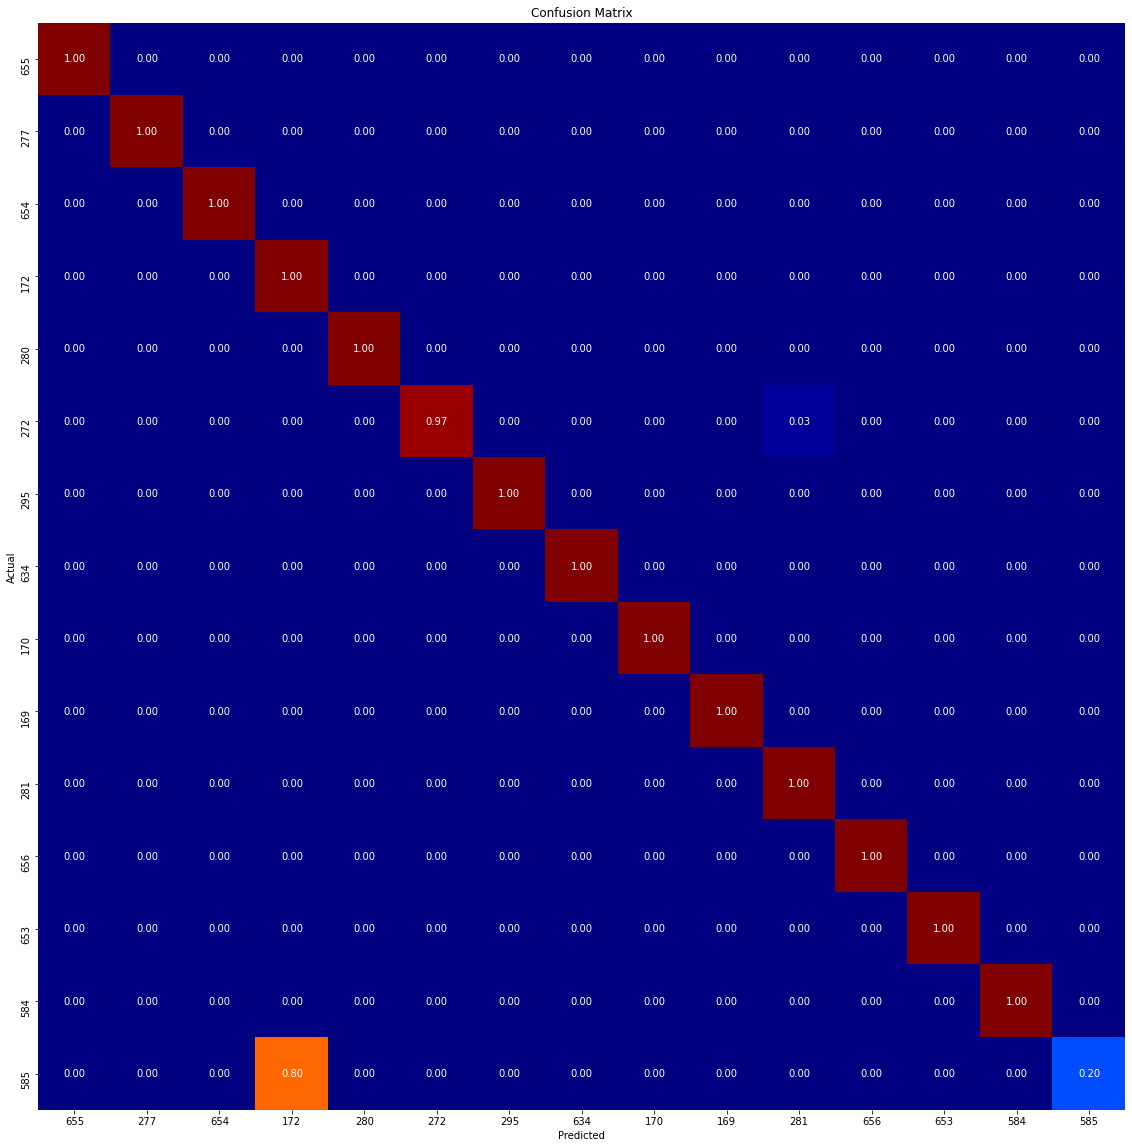

In [ ]:
class_report_res_sm = showClassficationReport_Generator(simple_model2, test_generator, STEP_SIZE_TEST)

In [ ]:
print('Classification Report SimpleModel with Top1 value:')
print(class_report_res_sm)

Classification Report SimpleModel with Top1 value:
              precision    recall  f1-score   support

         655       1.00      1.00      1.00        57
         277       1.00      1.00      1.00        46
         654       1.00      1.00      1.00        39
         172       0.90      1.00      0.95        38
         280       1.00      1.00      1.00        38
         272       1.00      0.97      0.99        38
         295       1.00      1.00      1.00        33
         634       1.00      1.00      1.00        28
         170       1.00      1.00      1.00        25
         169       1.00      1.00      1.00        20
         281       0.93      1.00      0.97        14
         656       1.00      1.00      1.00        10
         653       1.00      1.00      1.00        10
         584       1.00      1.00      1.00         6
         585       1.00      0.20      0.33         5

    accuracy                           0.99       407
   macro avg       0.99      

NameError: ignored

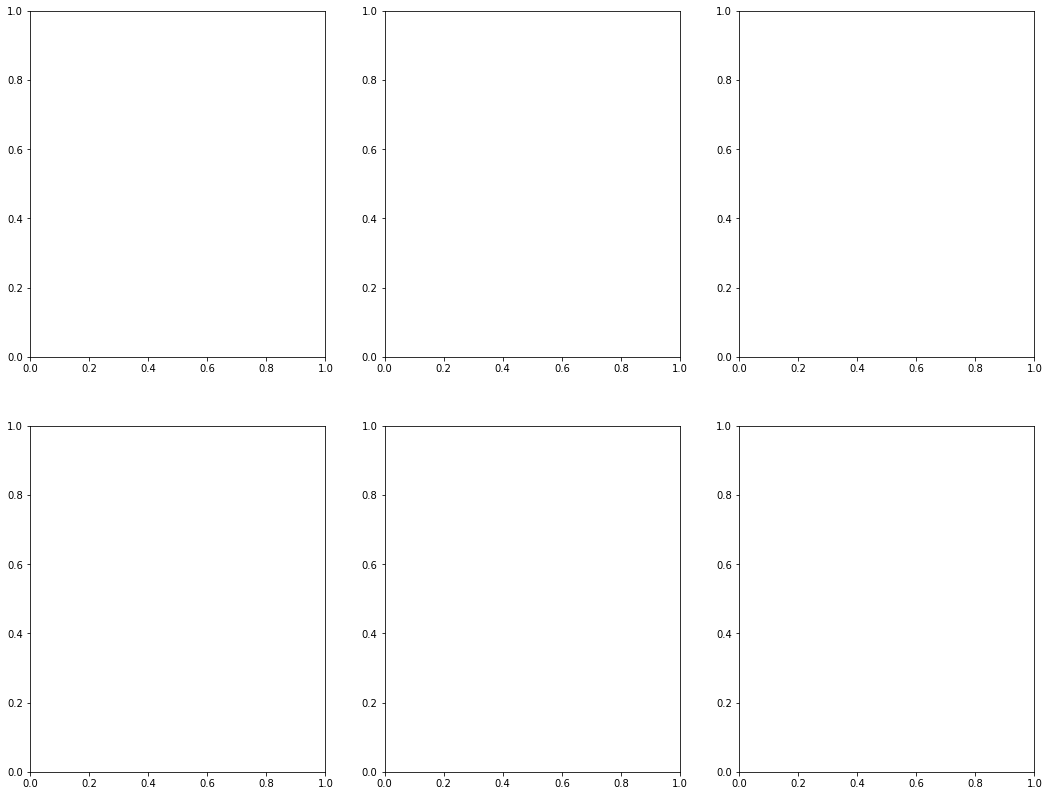

In [ ]:
# Prediction
from keras.preprocessing import *

n = 2
top_n = 3
fig, axes = plt.subplots(n, 3, figsize=(18,7*n))

for i in range(n):
    random_route = random.choice(routes_name)
    random_image = random.choice(os.listdir(os.path.join(images_dir, random_route)))
    random_image_file = os.path.join(images_dir, random_route, random_image)

    # Original image

    test_image = image.load_img(random_image_file, target_size=(train_input_shape[0:2]))

    # Predict artist
    test_image = image.img_to_array(test_image)
    test_image /= 255.
    test_image = np.expand_dims(test_image, axis=0)

    prediction = simple_model2.predict(test_image)
    prediction_probability = np.amax(prediction)
    prediction_idx = np.argmax(prediction)

    labels = train_generator.class_indices
    labels = dict((v,k) for k,v in labels.items())

    title = "Actual route = {}\nPredicted route = {}\nPrediction probability = {:.2f} %" \
                .format(random_route, labels[prediction_idx],
                        prediction_probability*100)
    axes[i][1].text(0,0.5,title,fontsize=15,family='serif')
    axes[i][1].axis('off')


    axes[i][0].imshow(plt.imread(random_image_file))


    axes[i][0].axis('off')

    top = list(enumerate(prediction[0]))
    top.sort(key= lambda x: x[1],reverse=True)
    probas = [p[1] for p in top[:top_n]]
    names = [labels[p[0] ]for p in top[:top_n]]

    x = np.arange(top_n)
    axes[i][2].bar(x,probas)
    axes[i][2].set_xticks(x)
    axes[i][2].set_xticklabels(names,rotation=15)
plt.savefig("abc.png")
plt.show()